# Analyses et Test

## Partie 1 – Scraping des annonces générales

Cette première partie a pour objectif de constituer un premier jeu de données à partir du site etreproprio.com.  
Le scraping est réalisé sur plusieurs villes françaises afin d’obtenir un échantillon large et diversifié, tout en maintenant un temps d’exécution raisonnable.

### Importation des bibliothèques nécessaires

Cette cellule permet d'importer les bibliotheques utilisées pour le scraping des données, leur traitement et la gestion du temps d'execution.  
- `requests` sert à envoyer des requetes HTTP  
- `BeautifulSoup` permet d'analyser le contenu HTML  
- `pandas` est utilisé pour manipuler les donnees sous forme de tableau  
- `time` et `random` servent à ajouter des pauses afin d'éviter une surcharge du serveur


In [ ]:
import requests
from bs4 import BeautifulSoup
import pandas as pd
import time
import random

### Paramètres de requete HTTP

Cette cellule definit les en-tetes HTTP utilises pour simuler une navigation classique par un humain, un utilisateur et non un robot afin de limiter les risques de blocage par le site.


In [ ]:
HEADERS = {
    "User-Agent": "Mozilla/5.0 (Macintosh; Intel Mac OS X 10_15_7) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/120.0.0.0 Safari/537.36",
    "Accept-Language": "fr-FR,fr;q=0.9"
}

### Fonction get_page

Cette fonction permet de charger une page de résultats pour une ville et un numéro de page donnés.  
L’URL est construite à partir du code de la ville et du numéro de page,  Cette phase utilise la fonction envoie une requête HTTP vers l’url correspondant à une combinaison “{city_code}r0.odd.g{page_number}”, qui conserve le code de la ville et la page, puis le contenu est converti en objet BeautifulSoup afin de faciliter l’extraction des données.

In [ ]:
def get_page(city_code, page_number):
    url = f"https://www.etreproprio.com/annonces/{city_code}-r0.odd.g{page_number}"
    response = requests.get(url, headers=HEADERS, timeout=10)
    return BeautifulSoup(response.content, "lxml")

### Fonction extract_info

Cette fonction permet d’extraire les informations directement visibles sur chaque annonce présente dans la liste de résultats. Les éléments récupérés sont le titre, la ville, le prix, la surface ainsi que l’URL de l’annonce.
Les annonces sont reconnues grâce à la classe HTML “.card-cla-search”,qui nous permet de cibler plus précisément cet élément HTLM : « `<div class="card-cla-search" data-seid="...">`», et sont ensuite extraites grâce à cette fonction 


In [ ]:
def extract_info(card):
    
    # ---- Titre ----
    title = card.select_one(".ep-title")
    title = title.get_text(strip=True) if title else None

    # ---- Villes ----
    city = card.select_one(".ep-city")
    city = city.get_text(strip=True) if city else None

    # ---- Prix ----
    price = card.select_one(".ep-price")
    price = price.get_text(strip=True) if price else None

    # ---- Surface ---- 
    surface = card.select_one(".ep-area")
    surface = surface.get_text(strip=True) if surface else None

    # ---- URL ----
    link_tag = card.find_parent("a")
    link = link_tag["href"] if link_tag else None
    if link and not link.startswith("https"):
        link = "https://www.etreproprio.com" + link

    return {
        "titre": title,
        "ville": city,
        "prix": price,
        "surface": surface,
        "url": link
    }

### Sélection des villes

Cette cellule contient la liste des codes correspondant à 41 villes françaises.  
Ces codes ont été récupérés manuellement afin de garantir la cohérence des résultats lors du scraping.


In [ ]:
villes = ["thflcpo.lc94080", #Vincennes 
          "thflcpo.lc69266", #Villeurbanne
          "thflcpo.lc75056", #Paris
          "thflcpo.lc31555", #Toulouse
          "thflcpo.lc06088", #Nice
          "thflcpo.lc44109", #Nantes 
          "thflcpo.lc34172", #Montpellier
          "thflcpo.lc67482", #Strasbourg
          "thflcpo.lc59350", #Lille
          "thflcpo.lc37261", #Tours
          "thflcpo.lc33063", #Bordeaux
          "thflcpo.lc35238", #Rennes
          "thflcpo.lc51454", #Reims
          "thflcpo.lc76351", #Le Havre
          "thflcpo.lc42218", #Saint-étienne
          "thflcpo.lc83137", #Toulon
          "thflcpo.lc38185", #Grenoble
          "thflcpo.lc21231", #Dijon
          "thflcpo.lc49007", #Angers
          "thflcpo.lc30189", #Nimes
          "thflcpo.lc63113", #Clermont-Ferrand
          "thflcpo.lc72181", #Le Mans
          "thflcpo.lc13001", #Aix en provence
          "thflcpo.lc29019", #Brest
          "thflcpo.lc80021", #Amiens
          "thflcpo.lc87085", #Limoges
          "thflcpo.lc74010", #Annecy
          "thflcpo.lc57463", #Metz
          "thflcpo.lc66136", #Perpignan
          "thflcpo.lc45234", #Orléans
          "thflcpo.lc76540", #Rouen
          "thflcpo.lc14118", #Caen
          "thflcpo.lc68224", #Mulhouse
          "thflcpo.lc54395", #Nancy
          "thflcpo.lc97411", #Saint Denis
          "thflcpo.lc84007", #Avignon
          "thflcpo.lc93048", #Montreuil
          "thflcpo.lc17300", #La Rochelle
          "thflcpo.lc64445", #Pau
          "thflcpo.lc86194", #Poitiers
          "thflcpo.lc28085", #Chartres
          ]

### Scraping des annonces par ville et par page

Dans un premier temps, une liste Python vide nommée `data` est créée.  
Cette liste a pour objectif de stocker progressivement l’ensemble des informations extraites lors du scraping.

Le script parcourt ensuite successivement chaque ville présente dans la liste `villes` grâce à une boucle `for`.  
Pour chaque ville, une seconde boucle permet de parcourir les six premières pages de résultats afin d’obtenir un échantillon suffisamment large, tout en maintenant un temps d’exécution raisonnable.

Lors de chaque passage, la fonction `get_page` est appelée pour récupérer le contenu HTML de la page correspondante.  
Les annonces sont ensuite identifiées à l’aide de la classe HTML `.card-cla-search`, ce qui permet de cibler précisément les cartes d’annonces.

Chaque annonce est traitée individuellement via la fonction `extract_info`, qui extrait les informations principales.  
Ces informations sont enrichies par le code de la ville et le numéro de la page, puis ajoutées à la liste `data`.

Enfin, une pause aléatoire est introduite entre chaque requête afin de limiter la charge envoyée au serveur et de réduire les risques de blocage.



In [ ]:
data = []

print("\n===== DÉBUT DU SCRAPING (41 VILLES) =====\n")

for city_code in villes:
    print(f"\n------------------------------")
    print(f"  📍 Ville : {city_code}")
    print(f"------------------------------")

    for page in range(1, 7):
        print(f"➡️  Page {page}")

        soup = get_page(city_code, page)
        cards = soup.select(".card-cla-search")

        if not cards:
            print("   ⛔ Aucune annonce → arrêt pour cette ville.")
            break

        for card in cards:
            info = extract_info(card)
            info["code_ville"] = city_code
            info["page"] = page
            data.append(info)

        time.sleep(random.uniform(1, 2))

### Création du fichier ANNONCES_RAW.csv

Les données collectées sont converties en DataFrame puis exportées dans un fichier CSV.  
Ce fichier constitue la base du projet et servira d’entrée pour le scraping détaillé que l'on va effectuer juste après. 


In [ ]:
df = pd.DataFrame(data)
df.to_csv("ANNONCES_RAW.csv", index=False)

In [ ]:
print("\n===== SCRAPING TERMINÉ =====")
print(f"🔎 Total annonces récupérées : {len(df)}")

## Partie 2 – Scraping détaillé des annonces

Cette seconde partie se concentre sur le scraping des pages individuelles de chaque annonce, accessibles grâce aux URLs collectées lors de la première phase.  
L’objectif est d’enrichir le jeu de données en récupérant des informations qui ne sont pas visibles dans les pages de résultats, comme le code postal, le type de bien ou le nombre de pièces.


### Paramètres généraux et fichiers utilisés

Cette cellule définit les en-têtes HTTP ainsi que les fichiers d’entrée et de sortie utilisés pour le scraping détaillé.  
Le fichier `ANNONCES_RAW.csv` contient les URLs issues du premier scraping, tandis que `ANNONCES_DETAILLEES.csv` accueillera les données finales enrichies.


In [ ]:
HEADERS = {
    "User-Agent": "Mozilla/5.0 (Macintosh; Intel Mac OS X 10_15_7) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/120.0.0.0 Safari/537.36",
    "Accept-Language": "fr-FR,fr;q=0.9"
}

INPUT_FILE = "ANNONCES_RAW.csv"
OUTPUT_FILE = "ANNONCES_DETAILLEES.csv"


### Fonction scrape_detail_page

Cette fonction permet de scraper une annonce individuellement à partir de son URL.  
Elle analyse le contenu HTML de la page afin d’extraire des informations plus détaillées que celles disponibles dans les pages de résultats.
La requête HTTP est encapsulée dans un bloc try / except afin de gérer les erreurs de connexion sans interrompre l’ensemble du processus.

- Le titre de l'annonce est extrait à partir de la balise principale de la page.

- La ville et le code postal sont initialement contenus dans un même élément HTML. Un traitement du texte est donc nécessaire afin de separer ces deux informations.(qui sont de base dans le même élément HTML, par exemple : "&nbsp ;Villeurbanne&nbsp ;69100&nbsp ;")

- Le type de bien est récupéré à partir du fil d'Ariane en haut de la page. Seul le deuxième élément est conservé, en l’indiquant comme ceci « li:nth-child(2) »

- Les informations complémentaires telles que le nombre de pieces, la surface et le prix sont extraits à partir de leurs éléments HTML respectifs.

- Les informations extraites sont regroupées dans un dictionnaire Python afin d'être facilement exploitées par la suite.


In [ ]:
def scrape_detail_page(url):
    """Scrape une page d'annonce EtreProprio et retourne un dictionnaire d'infos."""

    try:
        r = requests.get(url, headers=HEADERS, timeout=10)
        soup = BeautifulSoup(r.content, "lxml")

    except:
        print(f" Erreur de connexion pour : {url}")
        return None
     # ---- Titre ----
    titre = soup.select_one("h1")
    titre = titre.get_text(strip=True) if titre else None


    # --- Ville et Code Postal ----
    loc_tag = soup.select_one(".ep-loc")

    ville = None
    code_postal = None

    if loc_tag:
    
        texte = loc_tag.get_text(" ", strip=True)
        texte = texte.replace("—", "").strip()
        elements = texte.split()
        code_postal = elements[-1]
        ville = " ".join(elements[:-1])

    # ---- Type du bien ----
    type_tag = soup.select_one("div.ep-breadcrumb-cla-dir ol li:nth-child(2)")
    type_bien = type_tag.get_text(strip=True) if type_tag else None

    # ---- Nombre de pièces ----
    pieces_tag = soup.select_one(".ep-room")
    pieces = pieces_tag.get_text(strip=True) if pieces_tag else None

    # ---- Surface ---- 
    surface_tag = soup.select_one(".ep-area")
    surface = surface_tag.get_text(strip=True) if surface_tag else None

    # ---- Prix -----
    prix = soup.select_one(".ep-price")
    prix = prix.get_text(strip=True) if prix else None

    return {
        "titre": titre,
        "ville": ville,
        "code_postal": code_postal,
        "prix": prix,
        "surface": surface,
        "type_bien": type_bien,
        "pieces": pieces,
        "url": url
    }


### Chargement des URLs des annonces

Les URLs uniques sont extraites à partir du fichier issu du premier scraping.


In [ ]:
df = pd.read_csv(INPUT_FILE)
urls = df["url"].unique()
print(f"🔎 Nombre d'annonces à scraper : {len(urls)}")


### Initialisation du fichier de sortie

Le fichier CSV final est crée avec les colonnes attendues avant de lancer le scraping detaillé.


In [ ]:
# Création du CSV final
pd.DataFrame(columns=[
    "titre","ville","code_postal","prix",
    "surface", "type_bien", "pieces", "url"
]).to_csv(OUTPUT_FILE, index=False)

### Boucle de scraping detaillée

Chaque URL est traitée individuellement afin d'extraire et sauvegarder les informations detaillées.
Les données sont ajoutées au fichier CSV ligne par ligne.  
Des pauses aléatoires et régulières sont appliquées afin de limiter la charge serveur.


In [ ]:
for i, url in enumerate(urls):

    print(f"\n➡️  ({i+1}/{len(urls)}) Scraping : {url}")

    data = scrape_detail_page(url)

    if data:
        pd.DataFrame([data]).to_csv(OUTPUT_FILE, mode='a', header=False, index=False)
        print("   ✔ Données ajoutées")

    pause = random.uniform(1.2, 2.8)
    time.sleep(pause)

    if i % 20 == 0 and i != 0:
        print("⏸ Pause longue de 10 secondes…")
        time.sleep(10)

In [ ]:
print("\n Scraping détaillé terminé !")
print(f" Données enregistrées dans : {OUTPUT_FILE}")

## Partie 3 – Nettoyage et structuration

Cette partie a pour objectif de nettoyer, structurer et enrichir les données issues du scraping detaillé.  
Les traitements réalisés permettent de rendre le jeu de données exploitable pour les analyses statistiques.


### Importation des bibliothèques

Cette cellule permet d importer les bibliotheques necessaires au nettoyage des donnees, a la manipulation de texte et a la geolocalisation.


In [ ]:
import pandas as pd
import re
from geopy.geocoders import Nominatim
import time
import math


### Chargement du fichier de données

Le fichier CSV issu du scraping détaillé est chargé afin de lancer les opérations de nettoyage.


In [ ]:
df = pd.read_csv("ANNONCES_DETAILLEES.csv")


### Extraction des valeurs numériques

Dans les données issues du scraping, certaines informations numériques apparaissent sous forme de texte, mêlées à des caractères non numériques.  
Cette fonction permet d’extraire uniquement les chiffres présents dans une chaîne de caractères et de les convertir en valeur numérique.

Elle gère également les valeurs manquantes afin d’éviter des erreurs lors des conversions et des calculs ultérieurs.


In [ ]:
# ---- Extraction des nombres ----
def extraire_numero(valeur):
    if pd.isna(valeur):
        return None
    
    chiffres = re.findall(r'\d+', str(valeur))
    if len(chiffres) == 0:
        return None
    
    return int("".join(chiffres))

### Suppression des doublons

Certaines annonces peuvent apparaître plusieurs fois lors du scraping.  
Cette étape permet de garantir l’unicité de chaque bien immobilier dans le dataset.


In [ ]:
# --- Supprimer les doublons ----
df = df.drop_duplicates()

### Nettoyage des variables numériques

Les colonnes contenant des valeurs numériques (prix et surface) comportent des caractères non exploitables.  
Ces éléments sont supprimés afin de permettre leur conversion en valeurs numériques.


In [ ]:
# --- Nettoyer les doublons ---
df["prix"] = (
    df["prix"].astype(str)
    .str.replace("€", "", regex=False)
    .str.replace(" ", "")
    .str.replace("n.c.", "")      
)
# --- Convertir les vides en None ---
df["prix"] = df["prix"].replace("", None) 
# --- Conversion SANS ERREUR ---
df["prix"] = df["prix"].astype(float)    

### Nettoyage de la colonne surface

La surface contient des unités et des notations particulières.  
Le nettoyage permet de conserver uniquement la valeur numérique principale.


In [ ]:
# --- Nettoyer la Colonne Surface ---
df["surface"] = df["surface"].astype(str)
df["surface"] = df["surface"].str.replace("m²", "", regex=False)
df["surface"] = df["surface"].str.replace(" ", "")
df["surface"] = df["surface"].str.replace("n.c.", "", regex=False)
df["surface"] = df["surface"].str.split("/").str[0]
df["surface"] = df["surface"].str.replace("\u202f", "")
df["surface"] = df["surface"].str.replace("\xa0", "")
df["surface"] = df["surface"].replace("", None)

# convertir en float 
df["surface"] = df["surface"].astype(float)

### Nettoyage des colonnes catégorielles

Certaines colonnes comme le type de bien, le nombre de pièces et le code postal nécessitent un traitement spécifique afin d’être exploitables.


In [ ]:
# --- Nettoyage de la colonne Type_bien ---
df["type_bien"] = df["type_bien"].str.replace(">", "", regex=False).str.strip()
df["type_bien"] = df["type_bien"].apply(
    lambda x: x.split()[0] if isinstance(x, str) else x
)

# --- Nettoyage de la colonne Code_postal ---
df["code_postal"] = df["code_postal"].astype("Int64")

### Calcul du prix au mètre carré

Le prix au mètre carré est calculé à partir du prix et de la surface nettoyés.


In [ ]:
# --- Calcul du Prix au m2 ---
df["prix_m2"] = (df["prix"] / df["surface"]).round()

### Nettoyage de la colonne pièces

Le nombre de pièces apparaît dans les annonces sous forme de texte, généralement accompagné du mot « pièces ».  
Une extraction de la valeur numérique est donc réalisée à l’aide d’une expression régulière afin d’obtenir une variable strictement numérique.

La colonne est ensuite convertie en type entier, ce qui permet de faciliter les calculs et les comparaisons lors de l’analyse.


In [ ]:
# --- Nettoyage de la colonne Pièces ---
df["pieces"] = df["pieces"].astype(str).str.extract(r"(\d+)")
df["pieces"] = df["pieces"].astype("Int64")



### Harmonisation des variables numériques

Après les différentes opérations de nettoyage et de calcul, les variables numériques sont harmonisées en type entier.  
Cette étape permet d’assurer une cohérence de format dans l’ensemble du dataset et de faciliter les analyses statistiques ultérieures.


In [ ]:
# --- Nettoyage des nombres décimaux---
df["prix"] = df["prix"].astype("Int64")
df["surface"] = df["surface"].astype("Int64")
df["prix_m2"] = df["prix_m2"].astype("Int64")

### Géolocalisation des villes

Les villes sont géolocalisées afin d’obtenir leurs coordonnées géographiques nécessaires aux analyses spatiales.


In [ ]:
# --- Geolocalisation des villes ---
print("Géolocalisation des villes…")

df["ville"] = df["ville"].str.replace(r"Paris.*", "Paris", regex=True)

geolocator = Nominatim(user_agent="clean_script")
coord_villes = {}

villes = df["ville"].dropna().unique()

for v in villes:
    try:
        loc = geolocator.geocode(v)
        if loc:
            coord_villes[v] = (loc.latitude, loc.longitude)
        else:
            coord_villes[v] = (None, None)
        
        print(f"{v} → {coord_villes[v]}")
        time.sleep(1)
    except:
        coord_villes[v] = (None, None)

### Gestion des cas particuliers de localisation

Les différents arrondissements de Paris sont regroupés sous une seule entité afin d’assurer une géolocalisation cohérente.


In [ ]:
# --- Ajout des coordonnées ---
df["latitude"] = df["ville"].apply(lambda x: coord_villes.get(x, (None, None))[0])
df["longitude"] = df["ville"].apply(lambda x: coord_villes.get(x, (None, None))[1])


### Sauvegarde du dataset nettoyé

Le dataset nettoyé est sauvegardé afin d’être utilisé pour les analyses finales.


In [ ]:
# --- Sauvegarde ---
df.to_csv("ANNONCES_CLEAN.csv", index=False)

print("Nettoyage terminé ! Fichier créé : ANNONCES_CLEAN_FINAL.csv")
 

### Vérification des valeurs manquantes

Une vérification finale permet de contrôler la qualité du dataset.


In [ ]:
 
# --- Vérification des valeurs manquantes ---
print("\nValeurs manquantes par colonne :")
print(df.isna().sum())
print(df[df["ville"].isna()])

## Partie 4 – Analyse des données immobilières

Cette partie vise à analyser le jeu de données nettoyé afin d’identifier des tendances générales du marché immobilier.  
L’analyse repose sur des statistiques descriptives et des visualisations graphiques permettant de comparer les prix, les surfaces et les disparités entre villes.


### Importation des bibliothèques

Cette cellule importe les bibliothèques nécessaires à l’analyse statistique et à la visualisation des données.  
Un dossier dédié est également créé afin de sauvegarder automatiquement les figures produites.


In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os


df = pd.read_csv("ANNONCES_CLEAN.csv")
os.makedirs("figures", exist_ok=True)

### Sélection des appartements

L’analyse se concentre uniquement sur les appartements afin de garantir la comparabilité des biens.  
Les logements de types différents (maisons, terrains, etc.) présentent des caractéristiques trop hétérogènes pour être analysés ensemble de manière pertinente.


In [4]:
df_appart = df[df["type_bien"].str.contains("appart", case=False, na=False)]

### Statistiques descriptives générales

Cette étape permet d’obtenir une vue d’ensemble du dataset analysé :  
nombre total d’annonces, nombre d’appartements et nombre de villes représentées.  
Ces indicateurs servent à contextualiser les résultats présentés par la suite.


In [ ]:
print("Nombre total d'annonces :", len(df))
print("Nombre d'appartements :", len(df_appart))
print("Nombre de villes :", df_appart["ville"].nunique())


### Répartition des appartements par ville

Le nombre d’appartements par ville est calculé afin d’identifier les villes les plus représentées dans le dataset.  
Cette information est importante pour interpréter les résultats, car certaines villes disposent d’un échantillon plus large que d’autres.


In [ ]:
print(df_appart["ville"].value_counts())


### Calcul de la moyenne et médiane au mètre carré

Le prix au mètre carré est un indicateur central du marché immobilier. La moyenne elle, permet de mesurer le niveau général des prix, tandis que la médiane est moins sensible aux valeurs extrêmes et reflète mieux la situation typique du marché, la moitié des biens sont situés en dessous et une autre moitié au dessus.


In [7]:
moyenne_m2 = df_appart["prix_m2"].mean()
mediane_m2 = df_appart["prix_m2"].median()

### Répartition des prix selon les villes 

Le prix moyen des appartements est calculé pour chaque ville afin de comparer les niveaux de prix entre territoires. Cette approche permet d’identifier les villes les plus chères et les plus abordables du dataset.


In [ ]:
prix_ville = df_appart.groupby("ville")["prix"].mean().sort_values(ascending=False)

print("\n===== PRIX MOYEN PAR VILLE (Appartements) =====")
print(prix_ville.head(42))

### Visualisation du prix moyen des appartements par ville

Un graphique en barres est utilisé afin de visualiser clairement les écarts de prix moyens entre les villes. Ce type de graphique facilite la comparaison directe et met en évidence les disparités territoriales.


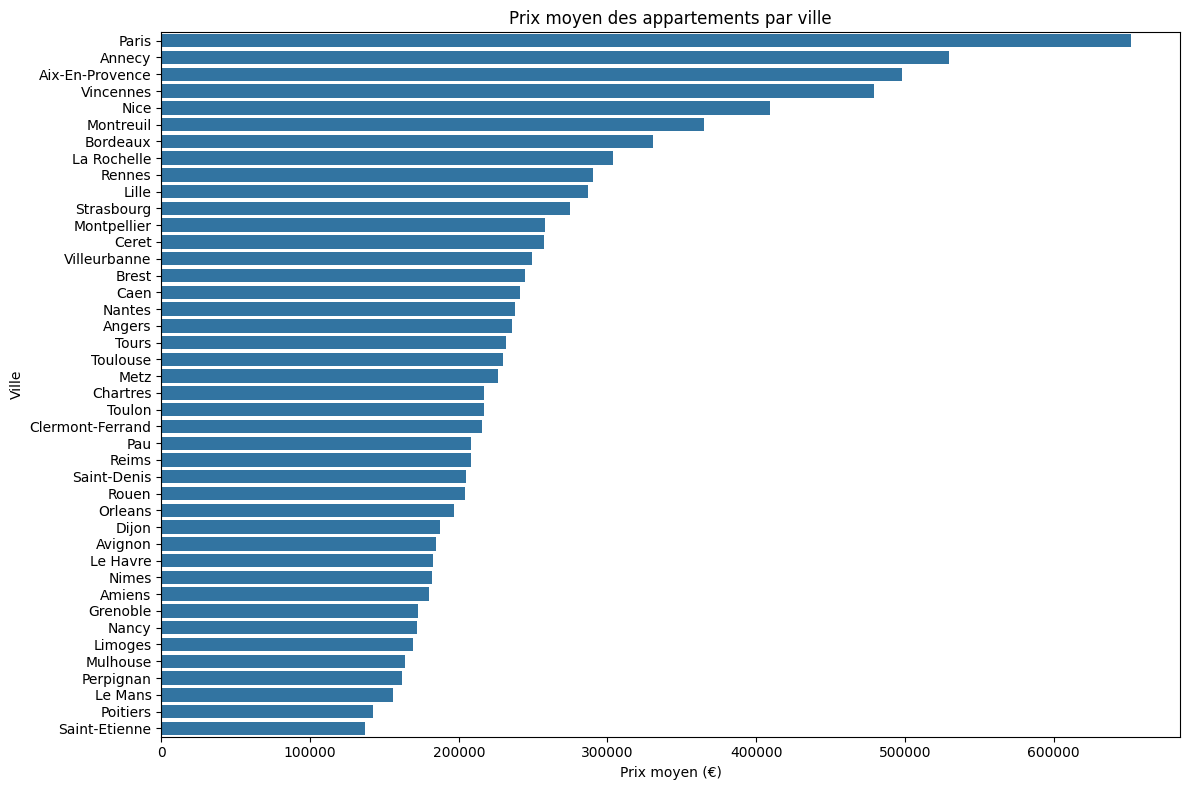

In [10]:
plt.figure(figsize=(12, 8))
sns.barplot(x=prix_ville.head(42).values, y=prix_ville.head(42).index)
plt.title("Prix moyen des appartements par ville")
plt.xlabel("Prix moyen (€)")
plt.ylabel("Ville")
plt.tight_layout()
plt.savefig("figures/prix_moyen_par_ville.png", dpi=300, bbox_inches='tight')
plt.show()

### Corrélation entre surface et prix

Cette analyse vise à mesurer le lien entre la surface d’un appartement et son prix.  
Le coefficient de corrélation permet d’évaluer dans quelle mesure l’augmentation de la surface est associée à une hausse du prix.


In [11]:
corr = df_appart["surface"].corr(df_appart["prix"])
print("\n===== CORRÉLATION =====")
print(f"Corrélation surface/prix : {corr:.3f}")


===== CORRÉLATION =====
Corrélation surface/prix : 0.306


### Visualisation de la relation entre surface et prix

Un nuage de points est utilisé afin d’observer graphiquement la relation entre la surface et le prix.  
Des limites sont fixées sur les axes afin d’exclure les valeurs extrêmes et de rendre la lecture plus lisible.


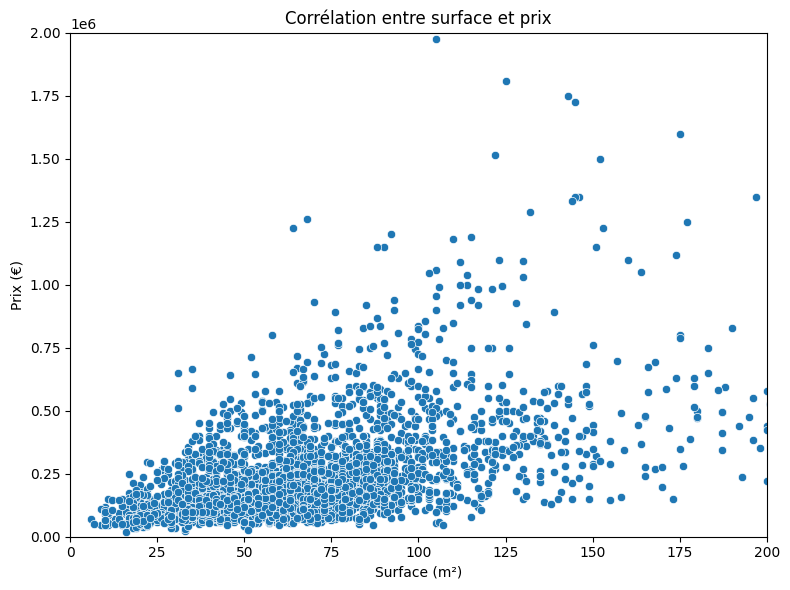

In [12]:
plt.figure(figsize=(8, 6))
sns.scatterplot(x="surface", y="prix", data=df_appart)
plt.xlim(0, 200)
plt.ylim(0, 2000000)
plt.title("Corrélation entre surface et prix")
plt.xlabel("Surface (m²)")
plt.ylabel("Prix (€)")
plt.tight_layout()
plt.savefig("figures/correlation_surface_prix.png", dpi=300, bbox_inches='tight')
plt.show()

### Distribution du prix au mètre carré

Un histogramme permet d’analyser la distribution globale du prix au mètre carré sur l’ensemble du dataset. L’ajout d’une courbe de densité facilite l’identification des valeurs les plus fréquentes.


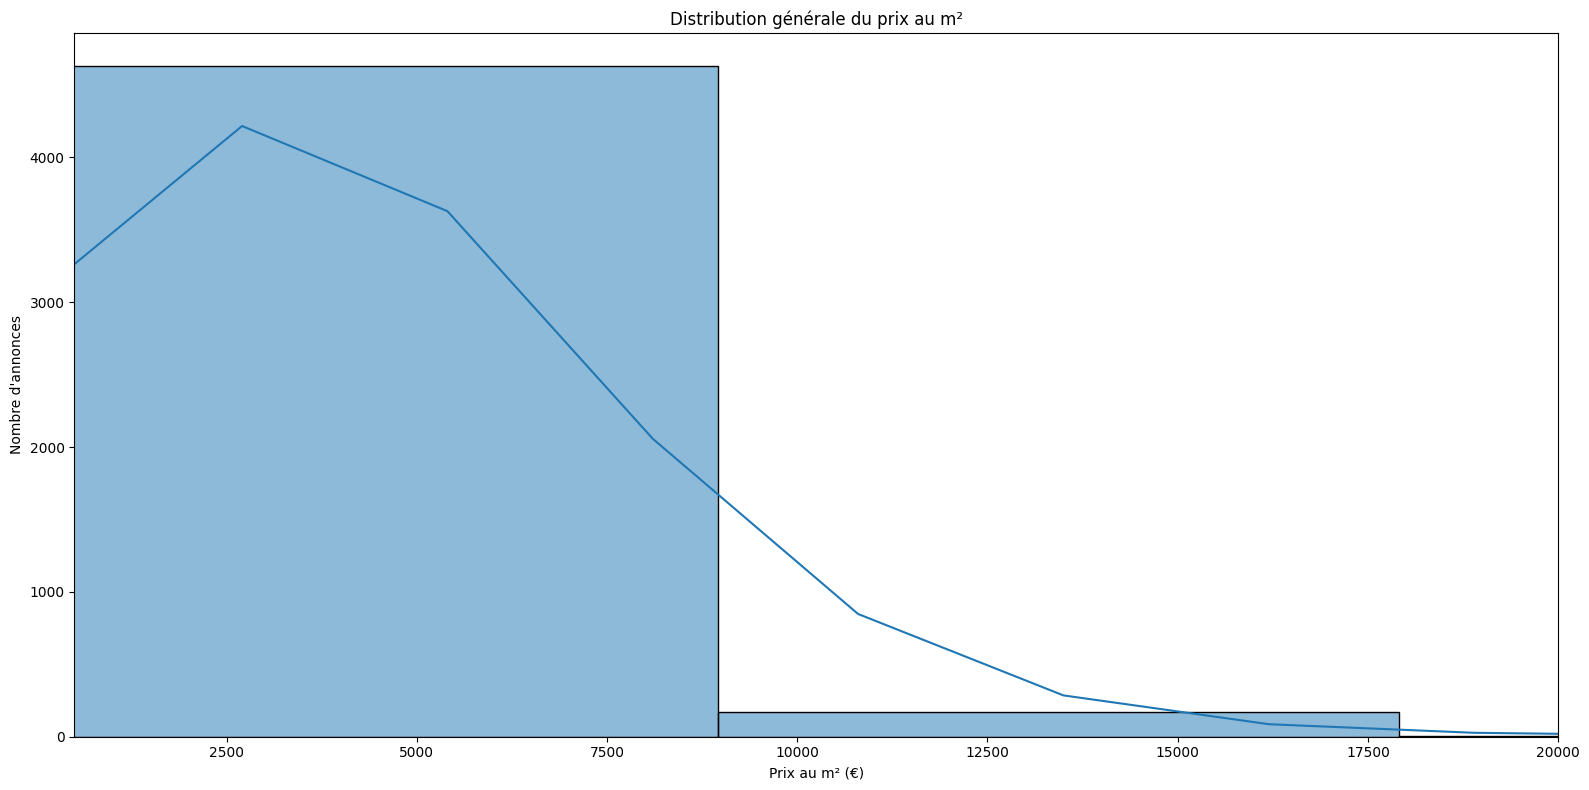

In [ ]:
plt.figure(figsize=(16, 8))
sns.histplot(df["prix_m2"], bins=60, kde=True)
plt.xlim(500, 20000)   # limite réaliste du marché
plt.title("Distribution générale du prix au m²")
plt.xlabel("Prix au m² (€)")
plt.ylabel("Nombre d'annonces")
plt.tight_layout()
plt.savefig("figures/histogramme_prix_m2.png", dpi=300, bbox_inches='tight')
plt.show()

### Comparaison des prix au m² par ville

Le boxplot permet d’analyser la dispersion des prix au mètre carré pour chaque ville.  
Il met en évidence la médiane, la variabilité et les éventuelles valeurs extrêmes.


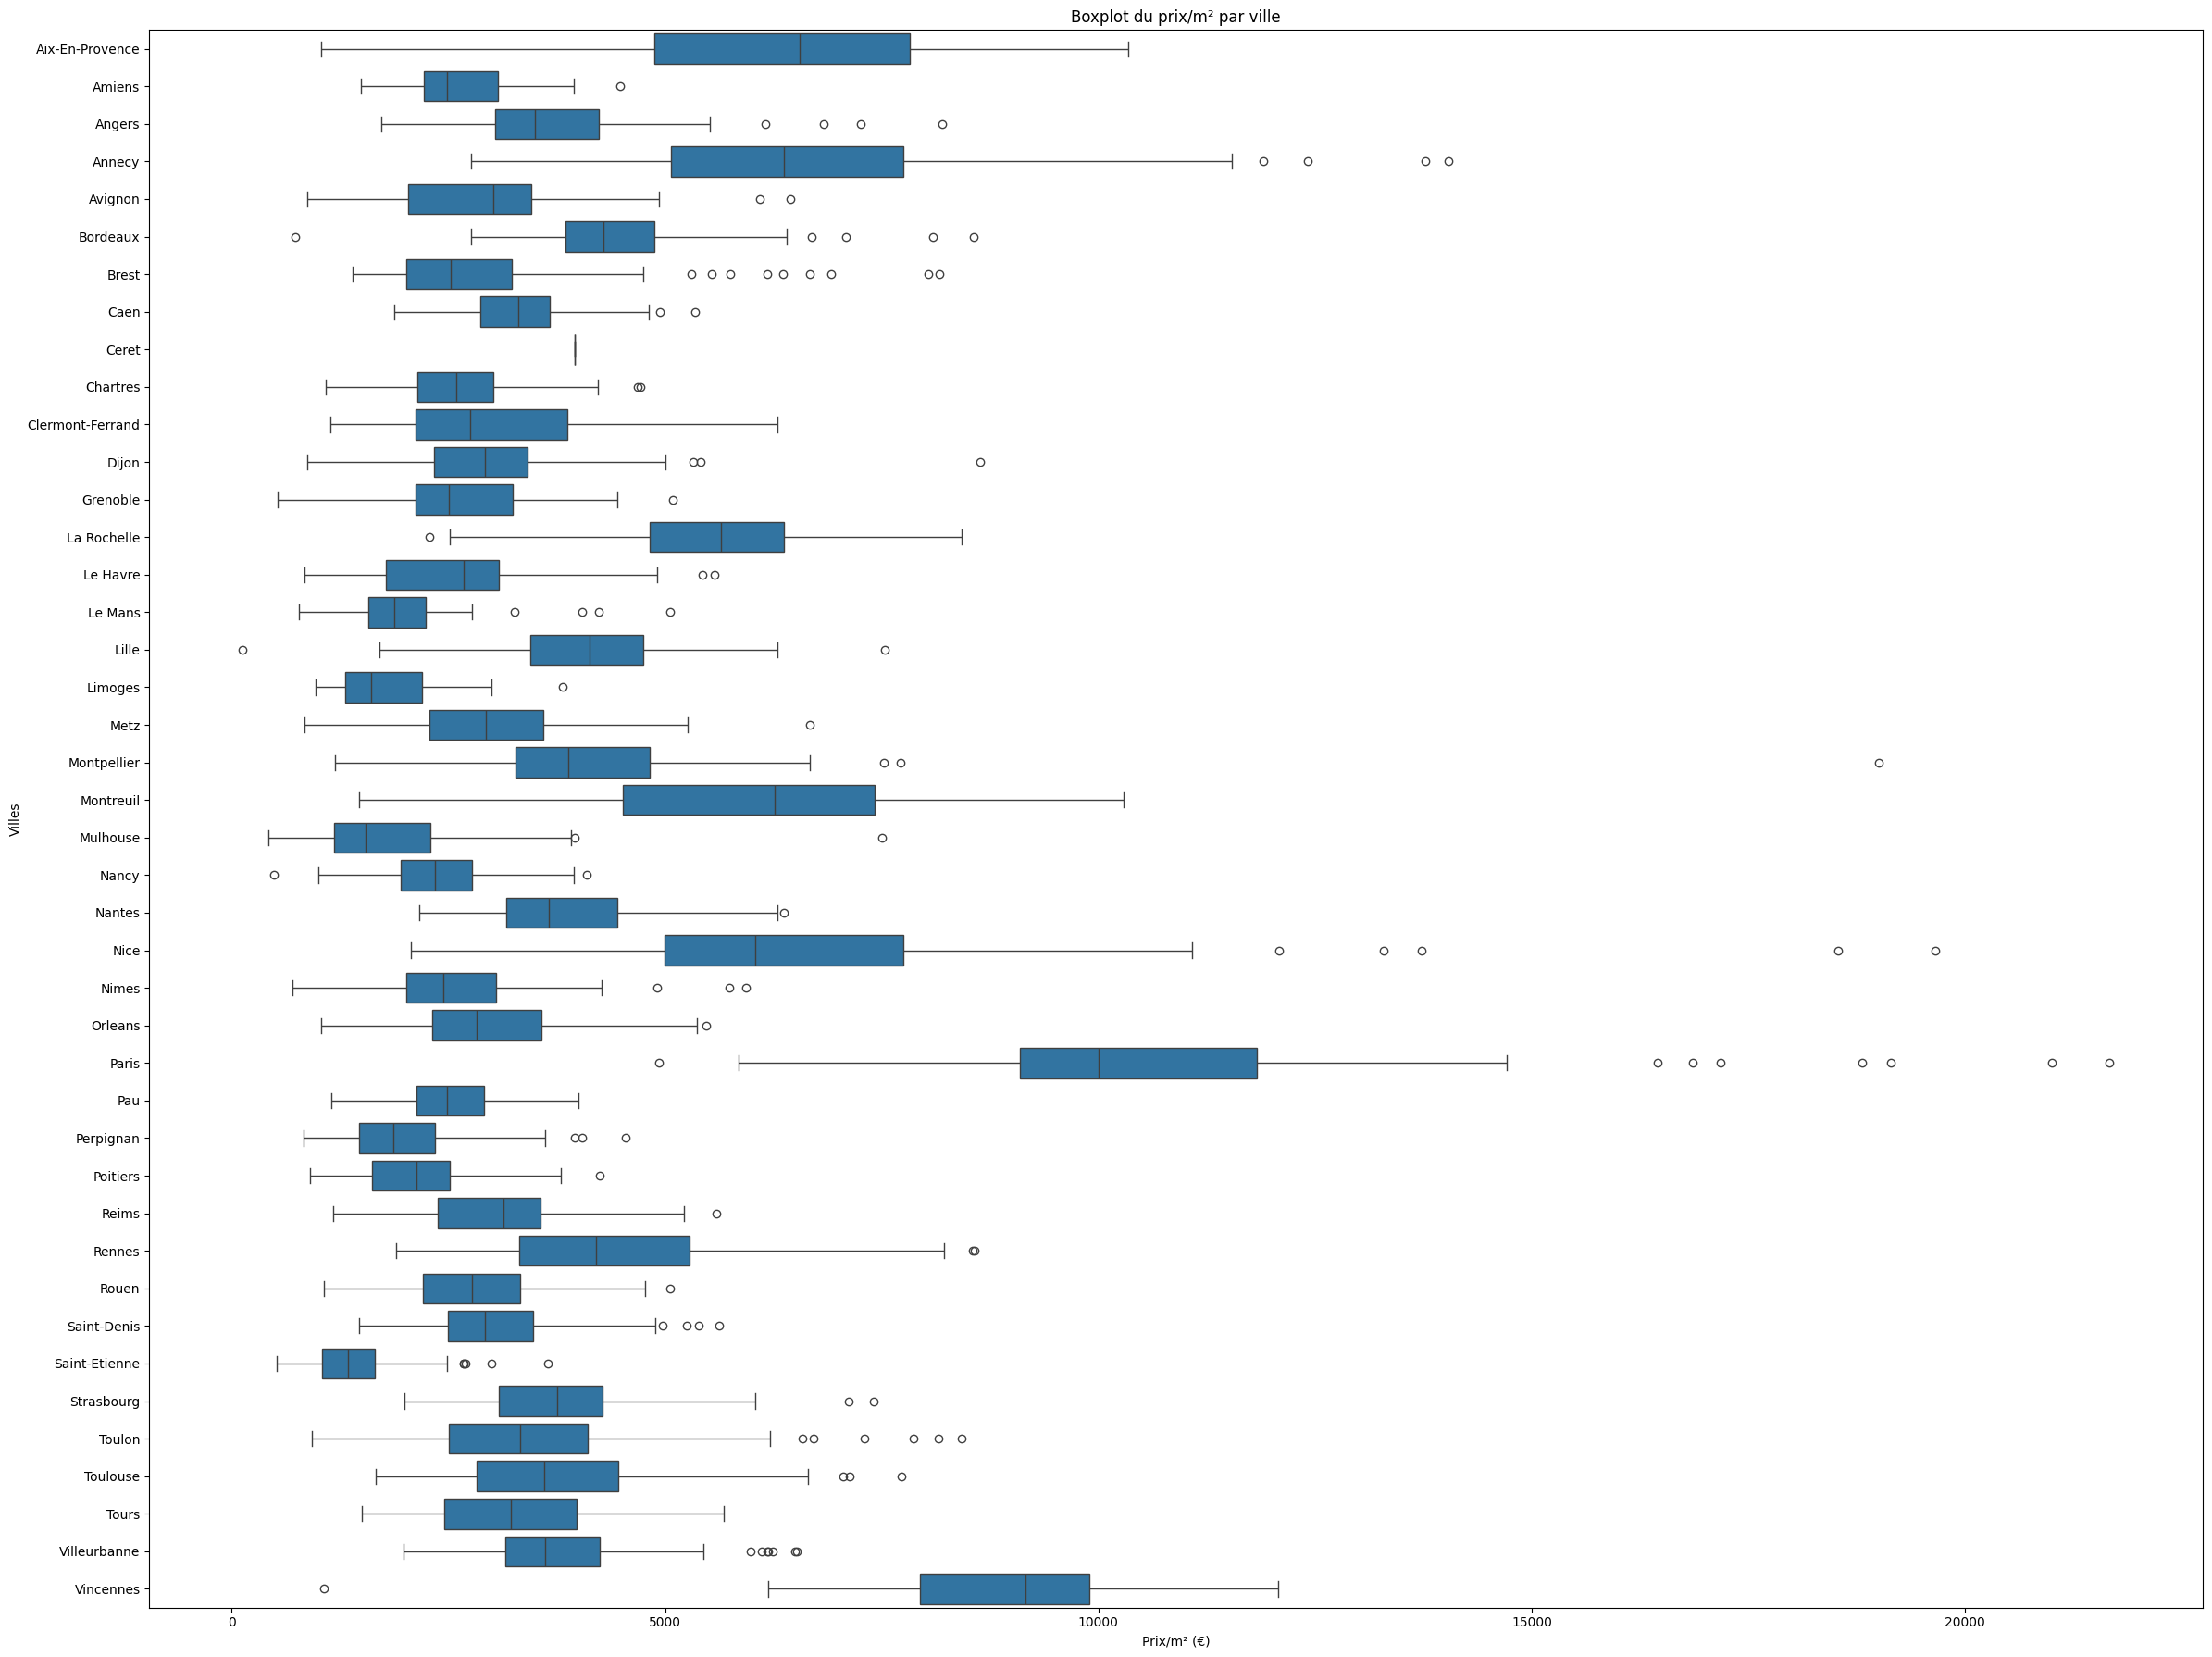

In [14]:
plt.figure(figsize=(24, 18))  
sns.boxplot(
    data=df_appart,
    y="ville",
    x="prix_m2",
    order=sorted(df_appart["ville"].unique()))
plt.title("Boxplot du prix/m² par ville")
plt.xlabel("Prix/m² (€)")
plt.ylabel("Villes")
plt.tight_layout()
plt.savefig("figures/boxplot_prix_m2.png", dpi=300, bbox_inches='tight')
plt.show()


### Analyse des 10 villes les plus chères

Les villes ayant le prix médian au mètre carré le plus élevé sont sélectionnées afin d’approfondir l’analyse. Cette visualisation permet de comparer la distribution des prix dans les marchés immobiliers les plus tendus.


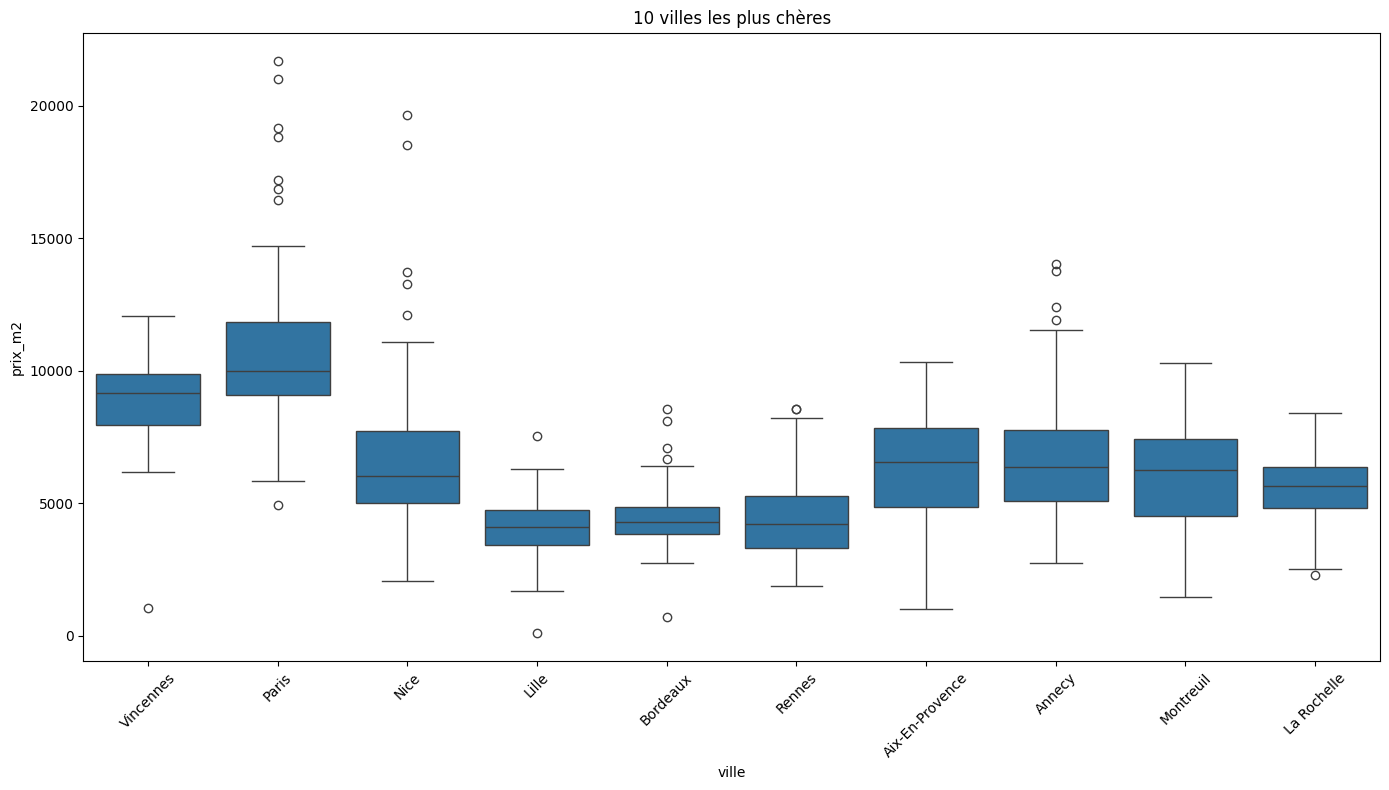

In [15]:
villes_cheres = df_appart.groupby("ville")["prix_m2"].median().sort_values(ascending=False).head(10).index

plt.figure(figsize=(14, 8))
sns.boxplot(x="ville", y="prix_m2", data=df_appart[df_appart["ville"].isin(villes_cheres)])
plt.xticks(rotation=45)
plt.title("10 villes les plus chères")
plt.tight_layout()
plt.savefig("figures/boxplot_10_villes_cheres.png", dpi=300, bbox_inches='tight')
plt.show()

### Barplot vertical complet du prix moyen au m² par ville

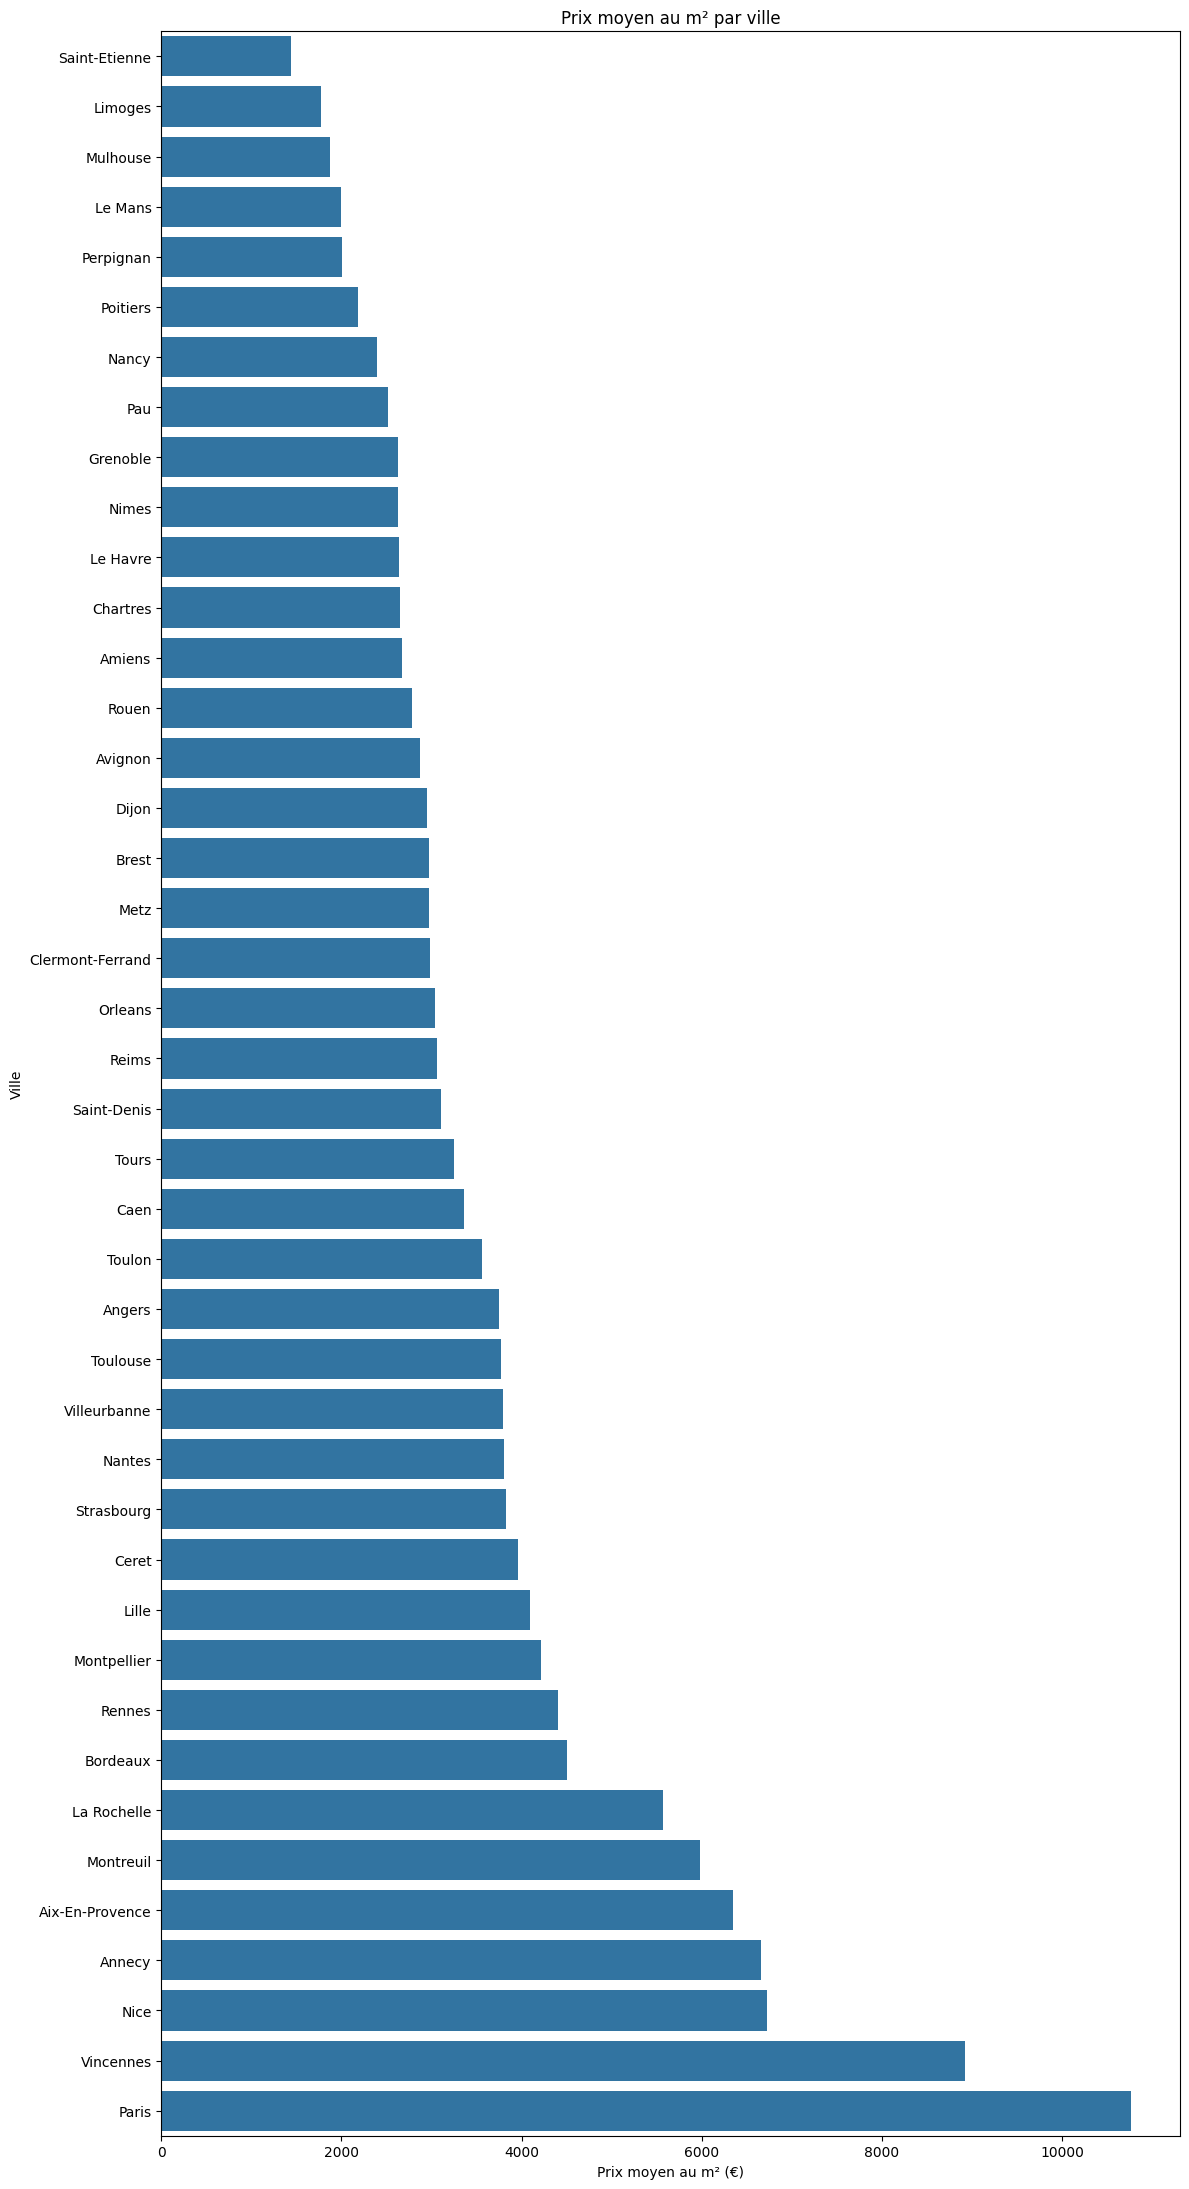

In [16]:
prix_par_ville = df_appart.groupby("ville")["prix_m2"].mean().sort_values()

plt.figure(figsize=(12, 22))
sns.barplot(x=prix_par_ville.values, y=prix_par_ville.index)
plt.title("Prix moyen au m² par ville")
plt.xlabel("Prix moyen au m² (€)")
plt.ylabel("Ville")
plt.tight_layout()
plt.savefig("figures/barplot_prix_moyen_au_m2.png", dpi=300, bbox_inches='tight')
plt.show()

### Analyse multivariée des variables numériques

Le pairplot permet d’explorer simultanément les relations entre plusieurs variables numériques (prix, surface, prix au m² et nombre de pièces).  
Un échantillon est utilisé afin de garantir une bonne lisibilité du graphique.


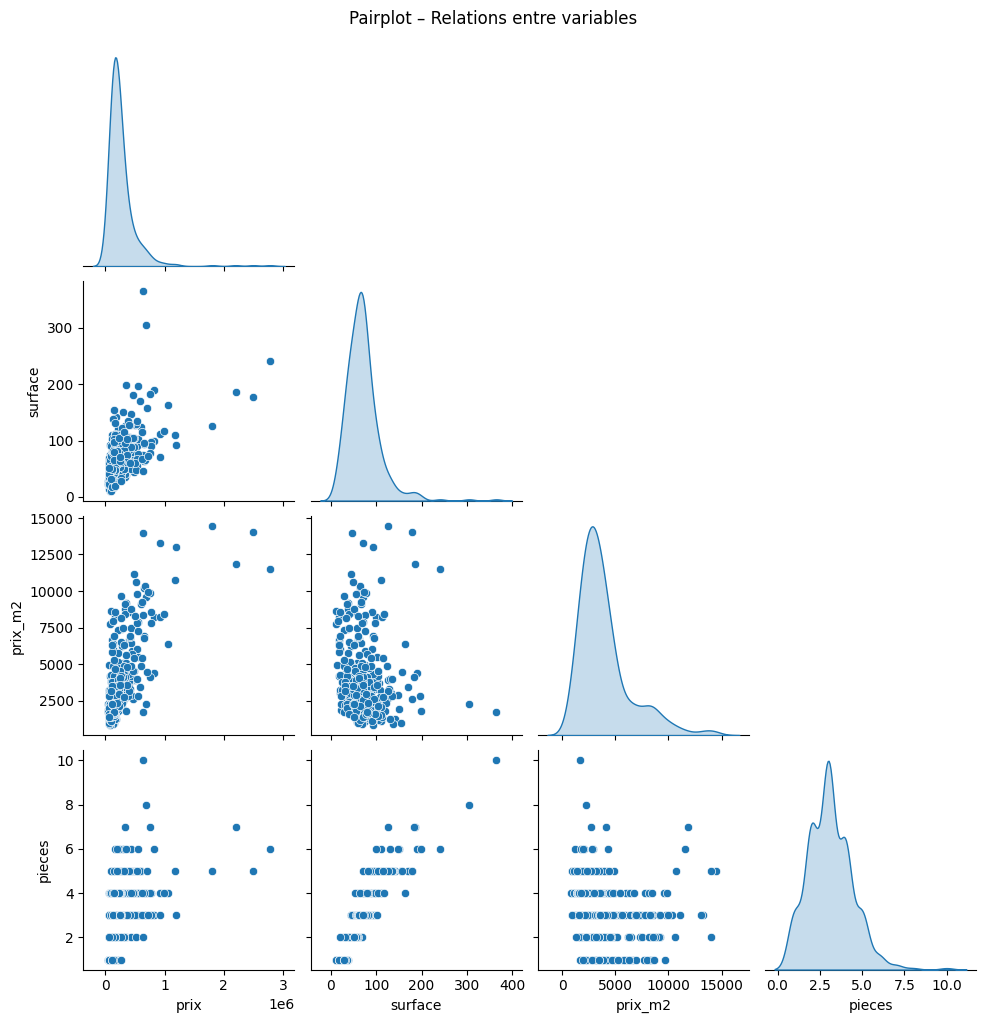

In [17]:
df_pair = df_appart[["prix", "surface", "prix_m2", "pieces"]].dropna()

df_pair = df_pair.sample(min(len(df_pair), 400), random_state=1)

sns.pairplot(df_pair, diag_kind="kde", corner=True)
plt.suptitle("Pairplot – Relations entre variables", y=1.02)
plt.savefig("figures/pairplot_variables.png", dpi=300, bbox_inches='tight')
plt.show()

In [ ]:
print("\nAnalyse des appartements terminée !")